In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import scipy
import nltk
from scipy.sparse import coo_matrix, hstack
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix

from scipy.spatial.distance import cdist

In [2]:
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

In [3]:
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBClassifier
from sklearn.metrics import cohen_kappa_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from Levenshtein import distance

loo = LeaveOneOut()

In [4]:
train = pd.read_csv('C:/Users/Dindar/crowdflower/tables1/train.csv')
test = pd.read_csv('C:/Users/Dindar/crowdflower/tables1/test.csv')

In [5]:
df = train[train['query'] == 'bridal shower decorations']
df['product_description'].fillna('0', inplace=True)
df_test = test[test['query'] == 'bridal shower decorations']
df_test['product_description'].fillna('0', inplace=True)

C:\Users\Dindar\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [6]:
df_all = pd.concat([df, df_test])

In [7]:
stop_words = set(stopwords.words('english')) 
df_all['query'] = df_all['query'].str.lower()
df_all['product_title'] = df_all['product_title'].str.lower()
df_all['product_description'] = df_all['product_description'].str.lower()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
df_all['query'] = df_all['query'].apply(lemmatize_text)
df_all['product_title'] = df_all['product_title'].apply(lemmatize_text)
df_all['product_description'] = df_all['product_description'].apply(lemmatize_text)
def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 = str1 + ' ' + ele      
    return str1[1:]
df_all['query'] = df_all['query'].apply(listToString)
df_all['product_title'] = df_all['product_title'].apply(listToString)
df_all['product_description'] = df_all['product_description'].apply(listToString)

# word2vec

In [8]:
import gensim

word2vec_path = "G:/Downloads/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [9]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions,col, generate_missing=False):
    embeddings = clean_questions[col].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [10]:
df_all['product_title'] = df_all['product_title'].str.split()
df_all['product_description'] = df_all['product_description'].str.split()

In [45]:
embeddings = get_word2vec_embeddings(word2vec, df_all,'product_description')
embeddings1 = get_word2vec_embeddings(word2vec, df_all,'product_title')
embeddings = np.asarray(embeddings)
embeddings1 = np.asarray(embeddings1)
embeddings = pd.DataFrame(embeddings)
embeddings1 = pd.DataFrame(embeddings1)

In [68]:
embeddings['target'] = df['median_relevance']
data = pd.concat([embeddings, embeddings1], axis=1)
df.set_index(pd.Index(list(range(43))), inplace=True)
df_all.set_index(pd.Index(list(range(119))), inplace=True)

In [69]:
data['target'] = df['median_relevance']

In [70]:
data['target_1'] = 0
data['target_1_2'] = 0
data['target_1_2_3'] = 0

In [71]:
data.loc[data['target']==1, 'target_1'] = 1
data.loc[(data['target']==1)|(data['target']==2), 'target_1_2'] = 1
data.loc[(data['target']==1)|(data['target']==2)|(data['target']==3), 'target_1_2_3'] = 1

In [74]:
target_1 = data['target_1']
target_1_2 = data['target_1_2']
target_1_2_3 = data['target_1_2_3']
data.drop(['target_1','target_1_2','target_1_2_3'],inplace=True,axis=1)

In [81]:
a = cdist(embeddings[:43], embeddings[:43], 'euclidean')
a = pd.DataFrame(a)

In [14]:
a.shape

(43, 43)

In [15]:
meann = []
maxx = []
minn = []
b = []
all_i = list(df.index)
for i in a.index:
    iii = a.iloc[i].sort_values()[:3].index
    meann.append(df.iloc[iii]['median_relevance'].mean())
    maxx.append(df.iloc[iii]['median_relevance'].max())
    minn.append(df.iloc[iii]['median_relevance'].min())

In [37]:
from sklearn.model_selection import KFold

In [83]:
a[train_index]

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,3.147129,3.199319,1.016770,1.289368,3.093706,3.351961,1.345861,3.175218,3.175134,...,0.901526,0.974508,0.419781,3.351961,2.185152,0.278436,0.751340,2.192533,1.289975,0.960922
1,3.147129,0.000000,4.417004,3.114634,2.090495,0.701082,3.809190,2.089873,0.869920,0.427361,...,3.044143,3.103394,3.125377,3.809190,1.231849,3.159319,3.063891,1.193297,2.075579,3.080946
2,3.199319,4.417004,0.000000,3.308013,3.286355,4.361226,1.000000,3.407864,4.477808,4.442377,...,3.226537,2.885593,3.220920,1.000000,3.565307,3.229524,3.185127,3.788426,3.383638,3.124614
3,1.016770,3.114634,3.308013,0.000000,1.266634,3.110089,3.455858,1.334586,3.001572,3.132910,...,0.816022,0.902331,0.978479,3.455858,2.195002,1.049195,0.779911,2.186262,1.220765,0.800632
4,1.289368,2.090495,3.286355,1.266634,0.000000,2.076117,3.130516,0.681360,2.157848,2.126073,...,1.162924,1.155440,1.250632,3.130516,1.154396,1.306919,1.105271,1.188839,0.496836,1.129214
5,3.093706,0.701082,4.361226,3.110089,2.076117,0.000000,3.744368,2.140739,0.851282,0.861382,...,3.082916,3.080163,3.077781,3.744368,1.224607,3.102398,3.044044,1.228040,2.093225,3.069772
6,3.351961,3.809190,1.000000,3.455858,3.130516,3.744368,0.000000,3.257842,3.879532,3.838582,...,3.377949,3.053956,3.372585,0.000000,3.116314,3.380802,3.338418,3.369298,3.232493,3.280734
7,1.345861,2.089873,3.407864,1.334586,0.681360,2.140739,3.257842,0.000000,2.196230,2.115183,...,1.045437,1.300584,1.307894,3.257842,1.259506,1.373671,1.181234,1.251323,0.511124,1.251668
8,3.175218,0.869920,4.477808,3.001572,2.157848,0.851282,3.879532,2.196230,0.000000,0.923081,...,3.116499,3.144524,3.164720,3.879532,1.366356,3.186233,3.108262,1.351221,2.127948,3.113757
9,3.175134,0.427361,4.442377,3.132910,2.126073,0.861382,3.838582,2.115183,0.923081,0.000000,...,3.062283,3.136026,3.150500,3.838582,1.293711,3.185916,3.091500,1.248075,2.105966,3.117329


In [75]:
a.iloc[test_index].iloc[0].sort_values()[:3].index

Int64Index([29, 18, 25], dtype='int64')

In [79]:
a.iloc[test_index]

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
29,0.941472,3.064468,3.220269,0.776916,1.140930,3.074836,3.371963,1.177931,3.107200,3.088527,...,3.056213,3.371963,3.064468,1.144792,3.064468,1.106719,3.220269,2.092563,1.455050,3.046083
30,0.909960,3.049207,3.208998,0.848626,1.131941,3.063716,3.361201,1.175394,3.126225,3.070206,...,3.057712,3.361201,3.049207,1.129745,3.049207,1.123541,3.208998,2.098995,1.409457,3.041611
31,0.814395,3.065061,3.177336,0.762937,1.112473,3.062422,3.330985,1.224487,3.104421,3.095334,...,3.071623,3.330985,3.065061,1.180581,3.065061,1.124337,3.177336,2.136265,1.420580,3.046267
32,2.254212,1.087491,3.838582,2.194339,1.232958,1.319841,3.425596,1.214084,1.360911,1.000000,...,1.186620,3.425596,1.087491,1.218295,1.087491,1.210033,3.838582,0.725212,1.555914,1.260534
33,3.116102,0.569101,4.427607,3.118225,2.100205,0.718448,3.821480,2.021382,0.872595,0.638801,...,0.000000,3.821480,0.569101,2.102750,0.569101,2.047889,4.427607,1.083558,2.312955,0.587576
34,3.351961,3.809190,1.000000,3.455858,3.130516,3.744368,0.000000,3.257842,3.879532,3.838582,...,3.821480,0.000000,3.809190,3.200531,3.809190,3.220758,1.000000,3.410932,3.361550,3.736899
35,3.147129,0.000000,4.417004,3.114634,2.090495,0.701082,3.809190,2.089873,0.869920,0.427361,...,0.569101,3.809190,0.000000,2.079003,0.000000,2.081844,4.417004,1.193304,2.303719,0.628934
36,1.380610,2.079003,3.353118,1.290537,0.597056,2.110458,3.200531,0.660668,2.170665,2.117603,...,2.102750,3.200531,2.079003,0.000000,2.079003,0.599133,3.353118,1.208580,1.154635,2.081634
37,3.147129,0.000000,4.417004,3.114634,2.090495,0.701082,3.809190,2.089873,0.869920,0.427361,...,0.569101,3.809190,0.000000,2.079003,0.000000,2.081844,4.417004,1.193304,2.303719,0.628934
38,1.288746,2.081844,3.372430,1.232124,0.491568,2.092343,3.220758,0.512682,2.134562,2.112861,...,2.047889,3.220758,2.081844,0.599133,2.081844,0.000000,3.372430,1.162120,1.102097,2.057056


In [16]:
a = cdist(embeddings.drop('target',axis=1), embeddings.drop('target',axis=1), 'euclidean')
a = pd.DataFrame(a)

In [17]:
iii_df = list(df.index)
for i in a[43:].index:
    iii = a.iloc[i].sort_values().index
    for j in iii:
        if j in iii_df:
            meann.append(meann[j])
            maxx.append(maxx[j])
            minn.append(minn[j])
            break
data['mean_4_lev_des'] = meann
data['max_4_lev_des'] = maxx
data['min_4_lev_des'] = minn

In [18]:
a = cdist(embeddings[:43], embeddings[:43], 'euclidean')
a = pd.DataFrame(a)

In [19]:
one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:3].index
    for j in df.iloc[iii]['median_relevance']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1

In [20]:
a = cdist(embeddings.drop('target',axis=1), embeddings.drop('target',axis=1), 'euclidean')
a = pd.DataFrame(a)

iii_df = list(df.index)
for i in a[43:].index:
    iii = a.iloc[i].sort_values().index
    for j in iii:
        if j in iii_df:
            one.append(one[j])
            two.append(two[j])
            three.append(three[j])
            four.append(four[j])
            break
data['one_4_lev'] = one
data['two_4_lev'] = two
data['three_4_lev'] = three
data['four_4_lev'] = four

# ++++++++++++++++++++++++++++++++++++++

In [21]:
embeddings1['target'] = df['median_relevance']

In [22]:
a = cdist(embeddings1[:43], embeddings1[:43], 'euclidean')
a = pd.DataFrame(a)

In [23]:
meann = []
maxx = []
minn = []
b = []
all_i = list(df.index)
for i in a.index:
    iii = a.iloc[i].sort_values()[:3].index
    meann.append(df.iloc[iii]['median_relevance'].mean())
    maxx.append(df.iloc[iii]['median_relevance'].max())
    minn.append(df.iloc[iii]['median_relevance'].min())

In [24]:
a = cdist(embeddings1.drop('target',axis=1), embeddings1.drop('target',axis=1), 'euclidean')
a = pd.DataFrame(a)

In [25]:
iii_df = list(df.index)
for i in a[43:].index:
    iii = a.iloc[i].sort_values().index
    for j in iii:
        if j in iii_df:
            meann.append(meann[j])
            maxx.append(maxx[j])
            minn.append(minn[j])
            break
data['mean_4_lev_title'] = meann
data['max_4_lev_title'] = maxx
data['min_4_lev_title'] = minn

In [27]:
a = cdist(embeddings1[:43], embeddings1[:43], 'euclidean')
a = pd.DataFrame(a)

In [28]:
one = []
two = []
three = []
four = []
for i in range(43):
    one.append(0)
    two.append(0)
    three.append(0)
    four.append(0)
for i in a.index:
    iii = a.iloc[i].sort_values()[:3].index
    for j in df.iloc[iii]['median_relevance']:
        if j == 1:
            one[i] = one[i] + 1
        elif j == 2:
            two[i] = two[i] + 1
        elif j == 3:
            three[i] = three[i] + 1
        elif j == 4:
            four[i] = four[i] + 1

In [29]:
a = cdist(embeddings1.drop('target',axis=1), embeddings1.drop('target',axis=1), 'euclidean')
a = pd.DataFrame(a)

iii_df = list(df.index)
for i in a[43:].index:
    iii = a.iloc[i].sort_values().index
    for j in iii:
        if j in iii_df:
            one.append(one[j])
            two.append(two[j])
            three.append(three[j])
            four.append(four[j])
            break
data['one_4_lev_title'] = one
data['two_4_lev_title'] = two
data['three_4_lev_title'] = three
data['four_4_lev_title'] = four

In [30]:
data_tr = data[:43][['two_4_lev',       'three_4_lev',        'four_4_lev',
        'mean_4_lev_title',   'max_4_lev_title',   'min_4_lev_title',
         'one_4_lev_title',   'two_4_lev_title', 'three_4_lev_title',
        'four_4_lev_title','mean_4_lev_des',  'max_4_lev_des',
        'min_4_lev_des',      'one_4_lev']]
data_ts = data[43:]
X = data_tr
y = df['median_relevance']
weight = 1 / (1 + df['relevance_variance'])

In [35]:
%%time
y_ts = []
y_pr = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    w = weight.values[train_index]
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_preds = xgb.predict(X_test)
    y_ts.append(y_test)
    y_pr.append(y_preds)
cohen_kappa_score(y_ts, y_pr ,weights='quadratic')# 4 - 56

Wall time: 2.81 s


0.9659270998415214

# ======================================================

In [114]:
train = pd.read_csv('C:/Users/Dindar/crowdflower/tables1/train.csv')
test = pd.read_csv('C:/Users/Dindar/crowdflower/tables1/test.csv')

In [174]:
%%time
res = []
count = 0
for i in train['query'].unique():
    df = train[train['query'] == i]
    df['product_description'].fillna('0', inplace=True)
    df_test = test[test['query'] == i]
    df_test['product_description'].fillna('0', inplace=True)
    df_all = pd.concat([df, df_test])
    stop_words = set(stopwords.words('english')) 
    df_all['query'] = df_all['query'].str.lower()
    df_all['product_title'] = df_all['product_title'].str.lower()
    df_all['product_description'] = df_all['product_description'].str.lower()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()

    def lemmatize_text(text):
        return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    df_all['query'] = df_all['query'].apply(lemmatize_text)
    df_all['product_title'] = df_all['product_title'].apply(lemmatize_text)
    df_all['product_description'] = df_all['product_description'].apply(lemmatize_text)
    def listToString(s):  
        str1 = ""  
        for ele in s:  
            str1 = str1 + ' ' + ele      
        return str1[1:]
    df_all['query'] = df_all['query'].apply(listToString)
    df_all['product_title'] = df_all['product_title'].apply(listToString)
    df_all['product_description'] = df_all['product_description'].apply(listToString)
    
    df_all['product_title'] = df_all['product_title'].str.split()
    df_all['product_description'] = df_all['product_description'].str.split()
    
    embeddings = get_word2vec_embeddings(word2vec, df_all,'product_description')
    embeddings1 = get_word2vec_embeddings(word2vec, df_all,'product_title')
    embeddings = np.asarray(embeddings)
    embeddings1 = np.asarray(embeddings1)
    embeddings = pd.DataFrame(embeddings)
    embeddings1 = pd.DataFrame(embeddings1)
    
    embeddings['target'] = df['median_relevance']
    data = pd.concat([embeddings, embeddings1], axis=1)
    df.set_index(pd.Index(list(range(df.shape[0]))), inplace=True)
    df_all.set_index(pd.Index(list(range(df_all.shape[0]))), inplace=True)
    a = cdist(embeddings[:df.shape[0]], embeddings[:df.shape[0]], 'euclidean')
    a = pd.DataFrame(a)
    meann = []
    maxx = []
    minn = []
    b = []
    all_i = list(df.index)
    for i in a.index:
        iii = a.iloc[i].sort_values()[:2].index
        meann.append(df.iloc[iii]['median_relevance'].mean())
        maxx.append(df.iloc[iii]['median_relevance'].max())
        minn.append(df.iloc[iii]['median_relevance'].min())
    a = cdist(embeddings.drop('target',axis=1), embeddings.drop('target',axis=1), 'euclidean')
    a = pd.DataFrame(a)
    iii_df = list(df.index)
    for i in a[df.shape[0]:].index:
        iii = a.iloc[i].sort_values().index
        for j in iii:
            if j in iii_df:
                meann.append(meann[j])
                maxx.append(maxx[j])
                minn.append(minn[j])
                break
    data['mean_4_lev_des'] = meann
    data['max_4_lev_des'] = pd.Series(maxx) - 1
    data['min_4_lev_des'] = minn
    a = cdist(embeddings[:df.shape[0]], embeddings[:df.shape[0]], 'euclidean')
    a = pd.DataFrame(a)
    
    one = []
    two = []
    three = []
    four = []
    for i in range(df.shape[0]):
        one.append(0)
        two.append(0)
        three.append(0)
        four.append(0)
    for i in a.index:
        iii = a.iloc[i].sort_values()[:2].index
        for j in df.iloc[iii]['median_relevance']:
            if j == 1:
                one[i] = one[i] + 1
            elif j == 2:
                two[i] = two[i] + 1
            elif j == 3:
                three[i] = three[i] + 1
            elif j == 4:
                four[i] = four[i] + 1
    
    a = cdist(embeddings.drop('target',axis=1), embeddings.drop('target',axis=1), 'euclidean')
    a = pd.DataFrame(a)

    iii_df = list(df.index)
    for i in a[df.shape[0]:].index:
        iii = a.iloc[i].sort_values().index
        for j in iii:
            if j in iii_df:
                one.append(one[j])
                two.append(two[j])
                three.append(three[j])
                four.append(four[j])
                break
    data['one_4_lev'] = one
    data['two_4_lev'] = two
    data['three_4_lev'] = three
    data['four_4_lev'] = pd.Series(four) - 2
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    embeddings1['target'] = df['median_relevance']
    a = cdist(embeddings1[:df.shape[0]], embeddings1[:df.shape[0]], 'euclidean')
    a = pd.DataFrame(a)
    meann = []
    maxx = []
    minn = []
    b = []
    all_i = list(df.index)
    for i in a.index:
        iii = a.iloc[i].sort_values()[:2].index
        meann.append(df.iloc[iii]['median_relevance'].mean())
        maxx.append(df.iloc[iii]['median_relevance'].max())
        minn.append(df.iloc[iii]['median_relevance'].min())
    a = cdist(embeddings1.drop('target',axis=1), embeddings1.drop('target',axis=1), 'euclidean')
    a = pd.DataFrame(a)
    iii_df = list(df.index)
    for i in a[df.shape[0]:].index:
        iii = a.iloc[i].sort_values().index
        for j in iii:
            if j in iii_df:
                meann.append(meann[j])
                maxx.append(maxx[j])
                minn.append(minn[j])
                break
    data['mean_4_lev_title'] = meann
    data['max_4_lev_title'] = pd.Series(maxx) - 1
    data['min_4_lev_title'] = minn
    a = cdist(embeddings1[:df.shape[0]], embeddings1[:df.shape[0]], 'euclidean')
    a = pd.DataFrame(a)
    one = []
    two = []
    three = []
    four = []
    for i in range(df.shape[0]):
        one.append(0)
        two.append(0)
        three.append(0)
        four.append(0)
    for i in a.index:
        iii = a.iloc[i].sort_values()[:2].index
        for j in df.iloc[iii]['median_relevance']:
            if j == 1:
                one[i] = one[i] + 1
            elif j == 2:
                two[i] = two[i] + 1
            elif j == 3:
                three[i] = three[i] + 1
            elif j == 4:
                four[i] = four[i] + 1
    a = cdist(embeddings1.drop('target',axis=1), embeddings1.drop('target',axis=1), 'euclidean')
    a = pd.DataFrame(a)

    iii_df = list(df.index)
    for i in a[df.shape[0]:].index:
        iii = a.iloc[i].sort_values().index
        for j in iii:
            if j in iii_df:
                one.append(one[j])
                two.append(two[j])
                three.append(three[j])
                four.append(four[j])
                break
    data['one_4_lev_title'] = one
    data['two_4_lev_title'] = two
    data['three_4_lev_title'] = three
    data['four_4_lev_title'] = pd.Series(four) - 2
    
    print('--------------------')
    
    data_tr = data[:df.shape[0]]
    data_ts = data[df.shape[0]:]
    X = data_tr
    y = df['median_relevance']
    weight = 1 / (1 + df['relevance_variance'])
    
    xgb = XGBClassifier()
    xgb.fit(X.values, y.values, sample_weight=weight)
    y_preds = xgb.predict(data_ts.values)
    res.append(dict(zip(list(df_test['id']), list(y_preds))))
    print(count)
    count += 1

C:\Users\Dindar\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


--------------------
0
--------------------
1
--------------------
2
--------------------
3
--------------------
4
--------------------
5
--------------------
6
--------------------
7
--------------------
8
--------------------
9
--------------------
10
--------------------
11
--------------------
12
--------------------
13
--------------------
14
--------------------
15
--------------------
16
--------------------
17
--------------------
18
--------------------
19
--------------------
20
--------------------
21
--------------------
22
--------------------
23
--------------------
24
--------------------
25
--------------------
26
--------------------
27
--------------------
28
--------------------
29
--------------------
30
--------------------
31
--------------------
32
--------------------
33
--------------------
34
--------------------
35
--------------------
36
--------------------
37
--------------------
38
--------------------
39
--------------------
40
--------------------
41
--

In [175]:
d = {}
for i in res:
    d.update(i)

In [176]:
ddd = pd.DataFrame.from_dict({'id':list(d.keys()),'pr':list(d.values())})

In [177]:
ddd.sort_values(by=['id'], inplace=True)

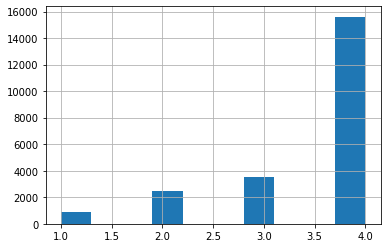

In [178]:
ddd['pr'].hist()

In [130]:
sample = pd.read_csv('G:/Downloads/crowdflower-search-relevance/sampleSubmission.csv/sampleSubmission.csv')

In [179]:
sample['prediction'] = list(ddd['pr'])

In [180]:
sample.to_csv('G:/Downloads/crowdflower-search-relevance/sampleSubmission.csv/sampleSubmission.csv', index=False)